In [238]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

from IS18 import utils
from bundle_adjust import ba_utils
from bundle_adjust import ba_core
import rpcm
import srtm4

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load input data

In [239]:
# list the tiff images available in the remote folder
IARPAurl = 'http://138.231.80.166:2332/iarpa-2016/cloud_optimized_geotif/'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
myimages = myimages[:6]
print('Found {} images'.format(len(myimages)))

# load rpcs
myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                        [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist() # add center field

# get image crops corresponding to the AOI
lon, lat = aoi['center']
alt = srtm4.srtm4(lon, lat)
mycrops = []
for iter_cont, f in enumerate(range(len(myimages))):
    crop, x0, y0 = rpcm.utils.crop_aoi(myimages[f], aoi, alt)
    mycrops.append({ 'crop': utils.simple_equalization_8bit(crop), 'x0': x0, 'y0': y0 })
    print('\r{} / {} done'.format(iter_cont+1, len(myimages)), end = '\r')
print('Finished cropping the AOI in each image')

# approximate rpcs as projection matrices
P_crop_gt = ba_core.approximate_rpcs_as_proj_matrices(myrpcs, mycrops, aoi, cam_model='Perspective')
n_cam = len(P_crop_gt)

# get limits of the 3D bounding box where 3D points will be defined
print('Synthetic 3D points will be defined within the following 3D boundig box:')
margin = 10
lon = np.array(aoi['coordinates'])[0,:,0]
lat = np.array(aoi['coordinates'])[0,:,1]
x,y,z = ba_utils.latlon_to_ecef_custom(lat, lon, [alt]*len(lat))
x_lim = (np.round(min(x)+margin,6), np.round(max(x)-margin,6))
y_lim = (np.round(min(y)+margin,6), np.round(max(y)-margin,6))
z_lim = (np.round(min(z)+margin,6), np.round(max(z)-margin,6))
print('X interval:', x_lim)
print('Y interval:', y_lim)
print('Z interval:', z_lim)

Found 6 images
Finished loading RPC coefficients
Finished cropping the AOI in each image
Approximating RPCs as Perspective projection matrices
6 projection matrices / 6 (0 err)
Done!

Synthetic 3D points will be defined within the following 3D boundig box:
X interval: (2743055.856693, 2743253.430292)
Y interval: (-4491297.877602, -4491129.095219)
Z interval: (-3591462.636365, -3591330.583896)


### Generate synthetic feature tracks

Generate as much feature tracks as desired. Then add Gaussian noise to the 3D coordinates of the points.

In [240]:
# this code generates random synthetic feature tracks in the space defined by (x_lim, y_lim, z_lim)

n_pts = 2000  # number of desired 3D points

feature_tracks_pts = np.zeros((n_pts, 2, n_cam))
r = np.zeros((n_pts, n_cam))
pts_3d_gt = np.zeros((n_pts,3))
n_success = 0
while n_success < n_pts:
    
    successful_3d_point = False
    
    while not successful_3d_point:
        
        successful_3d_point = True
        
        # select number of cameras where the point is seen
        n_im_where_visible = np.random.randint(2, n_cam+1, 1)[0]
    
        # generate camera indices
        ind_im_where_visible = np.unique(np.random.randint(0, n_cam, n_im_where_visible))
        
        if len(ind_im_where_visible) < 2:
            successful_3d_point = False
    
        # generate random 3d point within the established limits
        x = np.random.uniform(x_lim[0], x_lim[1])
        y = np.random.uniform(y_lim[0], y_lim[1])
        z = np.random.uniform(z_lim[0], z_lim[1])
        current_pt3d = np.vstack((x,y,z,1.))

        feature_tracks_pts[n_success,:,:] = np.zeros((1,2,n_cam))
        r[n_success,:] = np.zeros((1,n_cam))
        for im_ind in ind_im_where_visible:
            # get 2d projection in current image and check there are no negative coordinates
            current_pt2d = P_crop_gt[im_ind] @ current_pt3d
            current_pt2d = current_pt2d[:2, :] / current_pt2d[2, :]
            feature_tracks_pts[n_success,:,im_ind] = current_pt2d.ravel()
            r[n_success,im_ind] = 1
            
            if len(current_pt2d[current_pt2d<0]) > 0:
                successful_3d_point = False
            
        if successful_3d_point:
                pts_3d_gt[n_success,:] = current_pt3d[:3, :].ravel() / current_pt3d[3, :]
                successful_3d_point = True
                n_success += 1

from feature_tracks.feature_detection import corresp_matrix_from_tracks
C = np.around(corresp_matrix_from_tracks(feature_tracks_pts, r), 6)

# add noise
pts_3d_noisy = np.random.normal(pts_3d_gt, 10.)

print('Real  3D location:', pts_3d_gt[0,:].ravel())
print('Noisy 3D location:', pts_3d_noisy[0,:].ravel())

print('\nSynthetic feature tracks successfully generated')

Real  3D location: [ 2743139.6486139  -4491168.32495236 -3591434.5704958 ]
Noisy 3D location: [ 2743142.89543869 -4491166.57417513 -3591419.96209444]

Synthetic feature tracks successfully generated


### Add a random rotation to some of the cameras

In [241]:
from bundle_adjust.ba_rotations import euler_angles_to_R 

print('Adding a random rotation to each camera...')

P_crop_noisy = []
for cam_idx in range(n_cam):
    roll_deg = np.random.uniform(0.0, 0.0005)
    pitch_deg = np.random.uniform(0.0, 0.0005)
    yaw_deg = np.random.uniform(0.0, 0.0005)
    roll_rad = roll_deg * (np.pi/180.0)
    pitch_rad = pitch_deg * (np.pi/180.0)
    yaw_rad = yaw_deg * (np.pi/180.0)
    R_noise = euler_angles_to_R(np.array([roll_rad, pitch_rad, yaw_rad]))
    K, R, vecT, oC = ba_core.decompose_perspective_camera(P_crop_gt[cam_idx])
    new_R = R_noise @ R
    P_reconstructed = K @ new_R @ np.hstack((np.eye(3), - oC[:, np.newaxis]))
    P_crop_noisy.append(P_reconstructed/P_reconstructed[-1,-1])
    
print('...done!')

Adding a random rotation to each camera...
...done!


### Initialize Bundle Adjustment parameters

In [242]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''

im_ind = np.arange(n_cam)
pairs_to_triangulate = [(im_i, im_j) for im_i in im_ind for im_j in im_ind if im_i != im_j and im_i<im_j]
n_cam_fix = 0
n_cam_opt = n_cam-n_cam_fix
P_crop = P_crop_noisy.copy()

params_opt, cam_params, pts_3d, pts_2d, cam_ind, pts_ind, ba_params = \
ba_core.set_ba_params(P_crop, C, cam_model, n_cam_fix, n_cam_opt, pairs_to_triangulate, pts_3d=pts_3d_noisy)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}\n'.format(pts_3d.shape, cam_params.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

6 cameras in total, 0 fixed and 6 to be adjusted
3 parameters per camera and 2000 3d points to be optimized
pts_2d.shape:(6139, 2)  pts_ind.shape:(6139,)  cam_ind.shape:(6139,)
pts_3d.shape:(2000, 3)  cam_params.shape:(6, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run BA


Shape of matrix A: 12278x6018
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 6.6499e+06, final cost 2.1899e-03, first-order optimality 1.26e+02.
Optimization took 0 seconds
Error before BA (mean / median): 51.76 / 47.20
Error after  BA (mean / median): 0.00 / 0.00



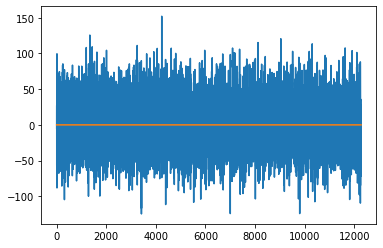

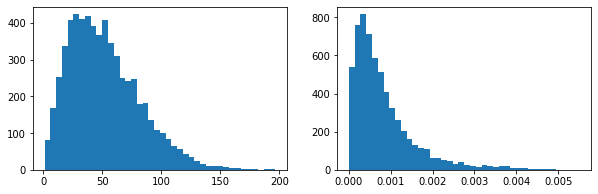

In [243]:
import time
from scipy.optimize import least_squares, minimize

# assign a weight to each observation
pts_2d_w = np.ones(pts_2d.shape[0])

# define input arguments
input_args = (cam_ind, pts_ind, pts_2d, cam_params, pts_3d, ba_params, pts_2d_w)

# compute loss value and plot residuals at the initial parameters
f0 = ba_core.fun(params_opt, *input_args)
plt.plot(f0)

# define jacobian
A = ba_core.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_core.fun, params_opt, jac_sparsity=A, verbose=1, x_scale='jac', method='trf', \
                    ftol=1e-4, xtol=1e-10, args=input_args)
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_core.get_ba_output(res.x, ba_params, cam_params, pts_3d)

# check BA error performance
ba_e = ba_core.check_ba_error(f0, res.fun, pts_2d_w)

In [244]:
# sanity check

fix_cam_ok = np.allclose(np.array(P_crop)[:n_cam_fix], np.array(P_crop_ba)[:n_cam_fix])
print('Did fixed cameras move? {}\n'.format('No' if fix_cam_ok else 'Yes'))

opt_cam_ok = np.allclose(np.array(P_crop)[:n_cam_opt], np.array(P_crop_ba)[:n_cam_opt])
print('Did cameras to adjust move? {}\n'.format('No' if opt_cam_ok else 'Yes'))

opt_cam_ok = np.allclose(pts_3d, pts_3d_ba)
print('Did 3d points move? {}\n'.format('No' if opt_cam_ok else 'Yes'))

Did fixed cameras move? No

Did cameras to adjust move? Yes

Did 3d points move? Yes



### Project initial and refined 3D location

Real  3D location: [ 2743160.50295901 -4491140.33361169 -3591427.21643345]
Noisy 3D location: [ 2743159.34083671 -4491133.12511419 -3591433.17903917]
3D location a. BA: [ 2743161.16195659 -4491139.30610475 -3591426.91220262] 

 ----> Real 2D loc in im 0  (sol) =  [97.608558 80.706804]
 ----> Proj 2D loc in im 0  b. BA =  [95.86576984 64.37308001]
 ----> Proj 2D loc in im 0  a. BA =  [97.60817874 80.70702191] 

 ----> Real 2D loc in im 2  (sol) =  [157.477749 103.307697]
 ----> Proj 2D loc in im 2  b. BA =  [149.1873837   71.11544754]
 ----> Proj 2D loc in im 2  a. BA =  [157.47733338 103.30780995] 

 ----> Real 2D loc in im 4  (sol) =  [176.426593  96.181705]
 ----> Proj 2D loc in im 4  b. BA =  [194.49641584  46.62054775]
 ----> Proj 2D loc in im 4  a. BA =  [176.42660774  96.1817715 ] 

 ----> Real 2D loc in im 5  (sol) =  [132.584975 101.528667]
 ----> Proj 2D loc in im 5  b. BA =  [131.81602797  67.00852569]
 ----> Proj 2D loc in im 5  a. BA =  [132.58564002 101.5283398 ] 

Initial

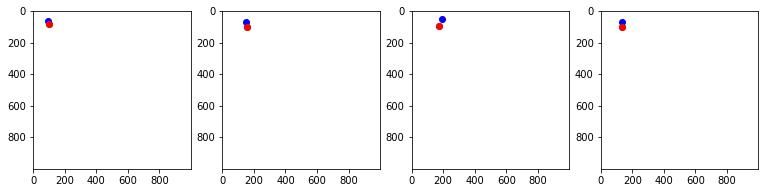

In [245]:
p_ind = np.random.choice(np.arange(pts_3d_ba.shape[0]).tolist())
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,ba_params['prev_pts_indices'][p_ind]])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(13,10))
for i in im_ind:   
    cont += 1
    
    p_2d_gt = C[(i*2):(i*2+2),ba_params['prev_pts_indices'][p_ind]]
    pt_3d_ba = np.expand_dims(pts_3d_ba[p_ind,:], axis=1).T
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
    reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    if cont == 0:
        print('Real  3D location:', pts_3d_gt[ba_params['prev_pts_indices'][p_ind], :].ravel())
        print('Noisy 3D location:', pts_3d[p_ind,:].ravel())
        print('3D location a. BA:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].plot(*p_2d_gt, "go")
    f[cont].plot(*p_2d_proj, "bo")
    f[cont].plot(*p_2d_proj_ba, "ro")
    
print('Initial Reprojection Error: ', reprojection_error)
print('Reprojection Error with BA: ', reprojection_error_ba)